In [1]:
!pip install pyspark



In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, regexp_replace, col

In [4]:
spark = SparkSession.builder.appName("AppStoreBigDataAnalysis").getOrCreate()

In [5]:
df = spark.read.csv("/content/google_playstore_cleaned.csv", header=True, inferSchema=True)

In [6]:
df.show(5)
df.printSchema()

+--------------------+----------------+-----------+---------+--------------------+------------------+-----+--------------+----------+
|            App Name|        Category|     Rating|  Reviews|            Installs|              Size|Price|Content Rating|Game_genre|
+--------------------+----------------+-----------+---------+--------------------+------------------+-----+--------------+----------+
|DoorDash - Food D...|  FOOD_AND_DRINK|4.548561573| 305034.0|5,000,000 - 10,00...|13.686153337739592|  0.0|      Everyone|      NULL|
|TripAdvisor Hotel...|TRAVEL_AND_LOCAL|4.400671482|1207922.0|100,000,000 - 500...|17.195525291828794|  0.0|      Everyone|      NULL|
|              Peapod|        SHOPPING|3.656329393|   1967.0|   100,000 - 500,000|               1.4|  0.0|      Everyone|      NULL|
|foodpanda - Local...|  FOOD_AND_DRINK|4.107232571| 389154.0|10,000,000 - 50,0...|              16.0|  0.0|      Everyone|      NULL|
|My CookBook Pro (...|  FOOD_AND_DRINK|4.647752285|   2291.0| 

In [7]:
# Extract lower bound of installs range and remove commas
df = df.withColumn("Installs_Lower", split(col("Installs"), " - ").getItem(0))
df = df.withColumn("Installs_Lower", regexp_replace("Installs_Lower", ",", "").cast("int"))

In [8]:
from pyspark.sql.functions import col

# -------------------------------
# 1. Top 10 Most Installed Apps
# -------------------------------
print("🔝 Top 10 Most Installed Apps")
df.select("App Name", "Installs_Lower") \
  .orderBy(col("Installs_Lower").desc()) \
  .show(10)

# -------------------------------
# 2. Average Rating by Category
# -------------------------------
print("\n⭐ Average Rating by Category")
df.groupBy("Category") \
  .agg({"Rating": "avg"}) \
  .orderBy("avg(Rating)", ascending=False) \
  .show(10)

# -------------------------------
# 3. Most Expensive Paid Apps
# -------------------------------
print("\n💰 Most Expensive Paid Apps")
df.filter(col("Price") > 0) \
  .select("App Name", "Price") \
  .orderBy(col("Price").desc()) \
  .show(10)

# -------------------------------
# 4. Number of Apps per Category
# -------------------------------
print("\n📊 Number of Apps in Each Category")
df.groupBy("Category") \
  .count() \
  .orderBy("count", ascending=False) \
  .show()


🔝 Top 10 Most Installed Apps
+--------------------+--------------+
|            App Name|Installs_Lower|
+--------------------+--------------+
|       Facebook Lite|    1000000000|
|   Google Play Music|    1000000000|
|Google Chrome: Fa...|    1000000000|
|Messenger � Text ...|    1000000000|
|        Google Drive|    1000000000|
|  WhatsApp Messenger|    1000000000|
|       Google Photos|    1000000000|
|Skype - free IM &...|    1000000000|
|         Cloud Print|    1000000000|
|  Google Street View|    1000000000|
+--------------------+--------------+
only showing top 10 rows


⭐ Average Rating by Category
+-------------------+------------------+
|           Category|       avg(Rating)|
+-------------------+------------------+
|BOOKS_AND_REFERENCE|4.4758281707557614|
|    PERSONALIZATION|4.4353194908650355|
|    MUSIC_AND_AUDIO|4.4309130967821675|
|             SOCIAL|4.3614251577862575|
|          EDUCATION|  4.34721890727517|
|          PARENTING| 4.340114931755235|
|             

In [9]:
df.groupBy("Category") \
  .sum("Installs_Lower") \
  .withColumnRenamed("sum(Installs_Lower)", "Total_Installs") \
  .orderBy(col("Total_Installs").desc()) \
  .show(10, truncate=False)


+---------------+--------------+
|Category       |Total_Installs|
+---------------+--------------+
|GAME           |44461452500   |
|TOOLS          |18842981100   |
|COMMUNICATION  |13274789800   |
|PRODUCTIVITY   |12725836600   |
|PHOTOGRAPHY    |9358091900    |
|ENTERTAINMENT  |7362587300    |
|SOCIAL         |7072460100    |
|MUSIC_AND_AUDIO|5836955500    |
|VIDEO_PLAYERS  |4658359100    |
|PERSONALIZATION|4186332300    |
+---------------+--------------+
only showing top 10 rows



In [10]:
df_paid = df.filter(col("Price") > 0)

df_paid = df_paid.withColumn("Revenue_Estimate", col("Price") * col("Installs_Lower"))

df_paid.groupBy("Category") \
  .sum("Revenue_Estimate") \
  .withColumnRenamed("sum(Revenue_Estimate)", "Estimated_Revenue") \
  .orderBy(col("Estimated_Revenue").desc()) \
  .show(10, truncate=False)


+------------------+-----------------+
|Category          |Estimated_Revenue|
+------------------+-----------------+
|GAME              |4.67434754E8     |
|TOOLS             |5.7997915E7      |
|PHOTOGRAPHY       |4.3291101E7      |
|MUSIC_AND_AUDIO   |4.0899219E7      |
|PRODUCTIVITY      |3.6115621E7      |
|EDUCATION         |3.6079027E7      |
|PERSONALIZATION   |2.888136E7       |
|BUSINESS          |2.8757208E7      |
|HEALTH_AND_FITNESS|2.3792043E7      |
|COMMUNICATION     |2.3424213E7      |
+------------------+-----------------+
only showing top 10 rows



In [11]:
df.filter((col("Rating") >= 4.5) & (col("Installs_Lower") < 10000)) \
  .select("App Name", "Rating", "Installs_Lower") \
  .orderBy(col("Rating").desc()) \
  .show(10, truncate=False)


+---------------------------------------------+------+--------------+
|App Name                                     |Rating|Installs_Lower|
+---------------------------------------------+------+--------------+
|Medical parasitology                         |5.0   |1000          |
|Old Town AH                                  |5.0   |0             |
|Oceania Revival Church                       |5.0   |0             |
|Voice Search Direct (assign to Bixby button) |5.0   |500           |
|Spectre Bowling                              |5.0   |0             |
|Better Claims                                |5.0   |100           |
|Life Church Adelaide                         |5.0   |0             |
|GreenDirect Puerto Rico                      |5.0   |100           |
|Dogs figurinhas para WhatsApp - WAStickerApps|5.0   |500           |
|Fantasy Mosaics 33: Inventor's Workshop      |5.0   |100           |
+---------------------------------------------+------+--------------+
only showing top 10 

In [12]:
df.groupBy("Category") \
  .agg({"Rating": "avg"}) \
  .withColumnRenamed("avg(Rating)", "Avg_Rating") \
  .orderBy(col("Avg_Rating")) \
  .show(10, truncate=False)


+-------------------+------------------+
|Category           |Avg_Rating        |
+-------------------+------------------+
|MAPS_AND_NAVIGATION|4.02207923141622  |
|HOUSE_AND_HOME     |4.037074062372973 |
|FINANCE            |4.041860142874298 |
|DATING             |4.045021063390094 |
|VIDEO_PLAYERS      |4.053698276480309 |
|AUTO_AND_VEHICLES  |4.126977879797529 |
|TRAVEL_AND_LOCAL   |4.130036330726461 |
|TOOLS              |4.142221027616834 |
|BUSINESS           |4.142819493913199 |
|PHOTOGRAPHY        |4.1673164333759685|
+-------------------+------------------+
only showing top 10 rows



In [13]:
df.select("Rating", "Reviews", "Size", "Price", "Installs_Lower") \
  .summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max") \
  .show()


+-------+------------------+-----------------+------------------+-------------------+--------------------+
|summary|            Rating|          Reviews|              Size|              Price|      Installs_Lower|
+-------+------------------+-----------------+------------------+-------------------+--------------------+
|  count|            267030|           267030|            267030|             267030|              267027|
|   mean| 4.269381556466779|14596.77026176834|15.899727389610101|0.22788046286934915|   584915.7190096881|
| stddev|0.5862496393966499|411071.5084306657|17.871933605288874|  3.559487405347677|1.1754033836814895E7|
|    min|               1.0|              1.0|               1.0|                0.0|                   0|
|    25%|       4.017543793|             16.0|               4.5|                0.0|                1000|
|    50%|       4.381987572|             93.0|               9.4|                0.0|               10000|
|    75%|       4.648648739|         

### Correlation between installs and rating

In [14]:
df.select("Installs_Lower", "Rating") \
  .corr("Installs_Lower", "Rating")


0.0038782041666959254

Distribution of app sizes

In [15]:
df.select("Size") \
  .summary("count", "mean", "stddev", "min", "max") \
  .show()


+-------+------------------+
|summary|              Size|
+-------+------------------+
|  count|            267030|
|   mean|15.899727389610101|
| stddev|17.871933605288874|
|    min|               1.0|
|    max|             347.0|
+-------+------------------+



In [16]:
from pyspark.sql.functions import when

df = df.withColumn("Paid_or_Free", when(col("Price") > 0, "Paid").otherwise("Free"))

df.groupBy("Paid_or_Free").count().show()


+------------+------+
|Paid_or_Free| count|
+------------+------+
|        Free|255424|
|        Paid| 11606|
+------------+------+



In [17]:
# Select only numeric columns
numeric_df = df.select("Rating", "Reviews", "Size", "Price", "Installs_Lower")

# Convert to pandas
pandas_df = numeric_df.toPandas()


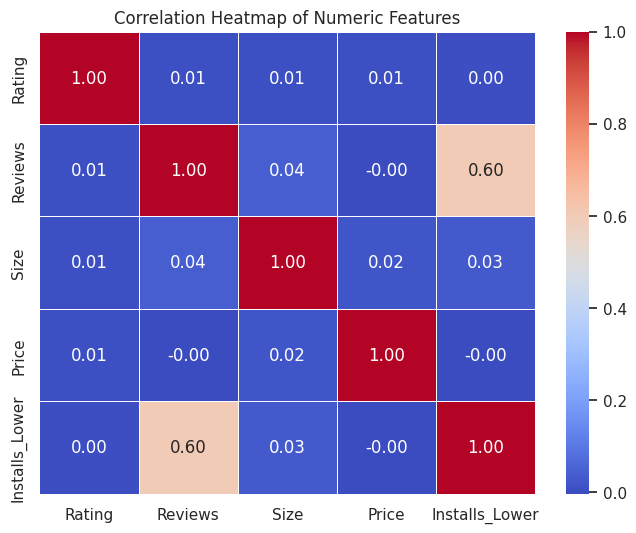

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="white")

# Calculate correlation matrix
corr_matrix = pandas_df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


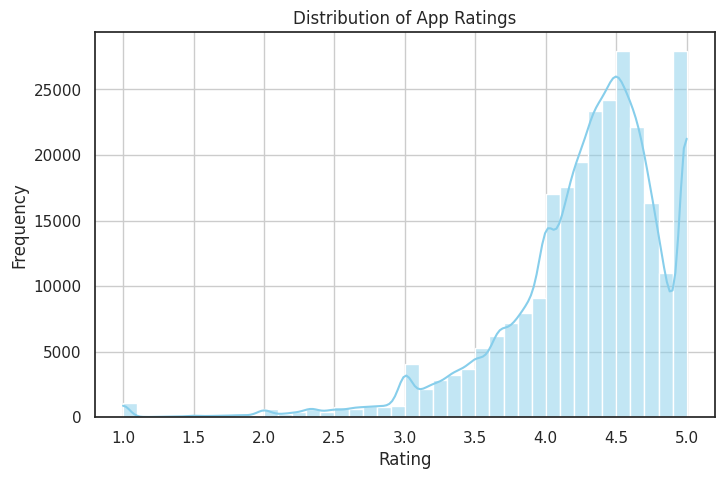

In [19]:
# Q: What is the distribution of app ratings?
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(pandas_df["Rating"], bins=40, kde=True, color='skyblue')
plt.title("Distribution of App Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


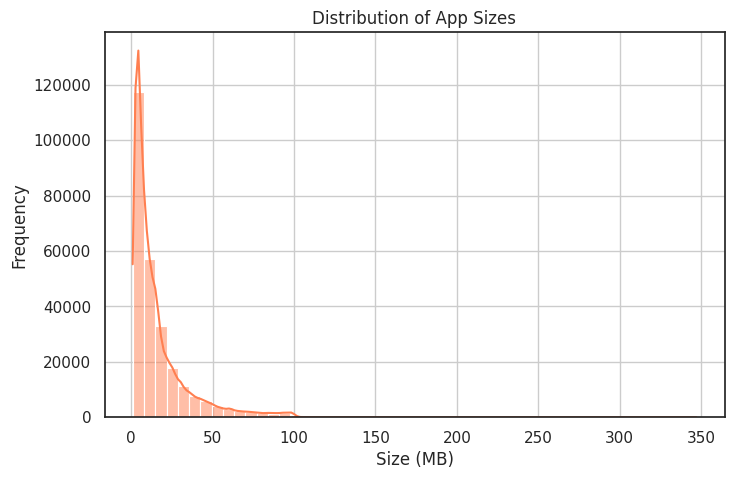

In [20]:
# Q: What is the distribution of app sizes?
plt.figure(figsize=(8,5))
sns.histplot(pandas_df["Size"], bins=50, kde=True, color='coral')
plt.title("Distribution of App Sizes")
plt.xlabel("Size (MB)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


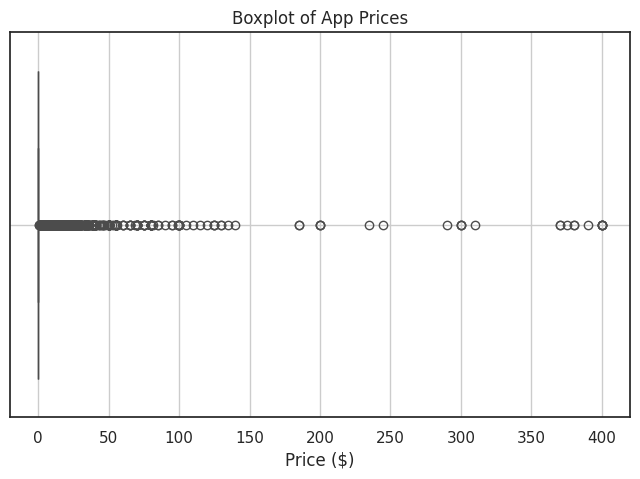

In [21]:
# Q: What does the price distribution of apps look like (with outliers)?
plt.figure(figsize=(8,5))
sns.boxplot(x=pandas_df["Price"])
plt.title("Boxplot of App Prices")
plt.xlabel("Price ($)")
plt.grid(True)
plt.show()



In [23]:
# Recreate 'Paid_or_Free' in Spark (if not already there)
from pyspark.sql.functions import when

df = df.withColumn("Paid_or_Free", when(col("Price") > 0, "Paid").otherwise("Free"))

# Select numeric + new column and convert to Pandas
numeric_df = df.select("Rating", "Reviews", "Size", "Price", "Installs_Lower", "Paid_or_Free")
pandas_df = numeric_df.toPandas()



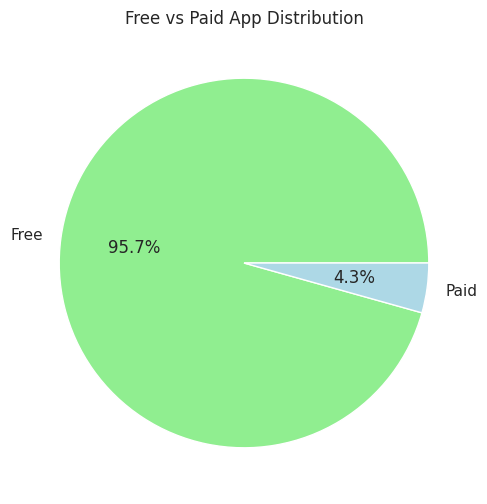

In [24]:
# Q: What proportion of apps are free vs paid?
labels = pandas_df["Paid_or_Free"].value_counts().index
sizes = pandas_df["Paid_or_Free"].value_counts().values

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightblue'])
plt.title("Free vs Paid App Distribution")
plt.show()


/tmp/ipython-input-29-217865341.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories_pd, x="count", y="Category", palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


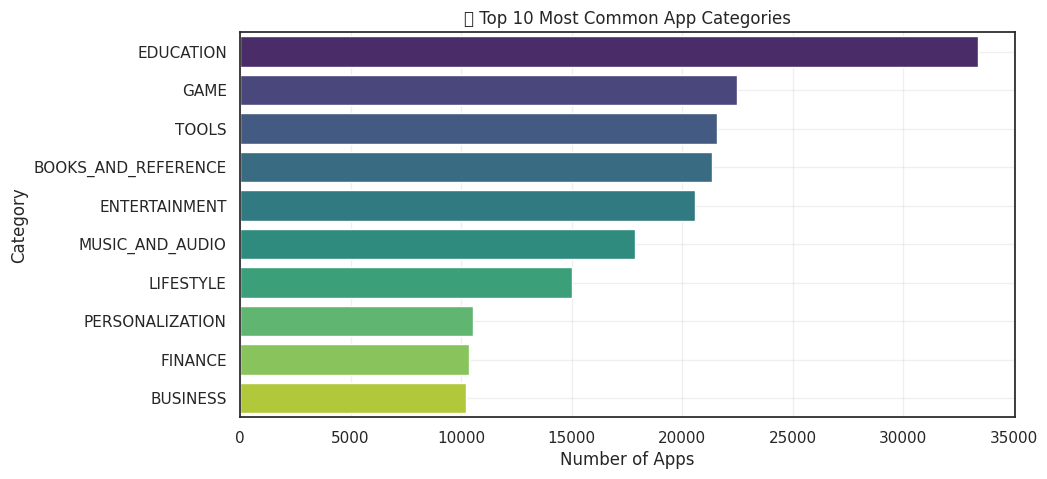

In [29]:
# Q: What are the most common app categories on the Play Store?
top_categories = df.groupBy("Category").count().orderBy("count", ascending=False).limit(10)
top_categories_pd = top_categories.toPandas()

plt.figure(figsize=(10,5))
sns.barplot(data=top_categories_pd, x="count", y="Category", palette="viridis")
plt.title("📚 Top 10 Most Common App Categories")
plt.xlabel("Number of Apps")
plt.ylabel("Category")
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipython-input-30-3937837201.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_rating_by_cat, x="avg(Rating)", y="Category", palette="cubehelix")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


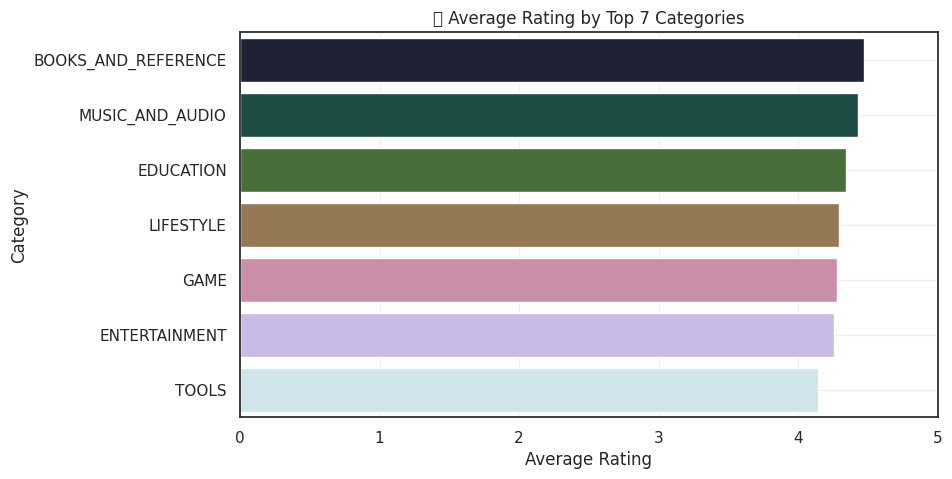

In [30]:
# Q: Which categories have the highest average ratings?
top7 = top_categories_pd["Category"].tolist()[:7]

avg_rating_by_cat = df.filter(df.Category.isin(top7)) \
    .groupBy("Category").avg("Rating") \
    .orderBy("avg(Rating)", ascending=False).toPandas()

plt.figure(figsize=(9,5))
sns.barplot(data=avg_rating_by_cat, x="avg(Rating)", y="Category", palette="cubehelix")
plt.title("⭐ Average Rating by Top 7 Categories")
plt.xlabel("Average Rating")
plt.ylabel("Category")
plt.xlim(0, 5)
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipython-input-41-2602170963.py:15: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


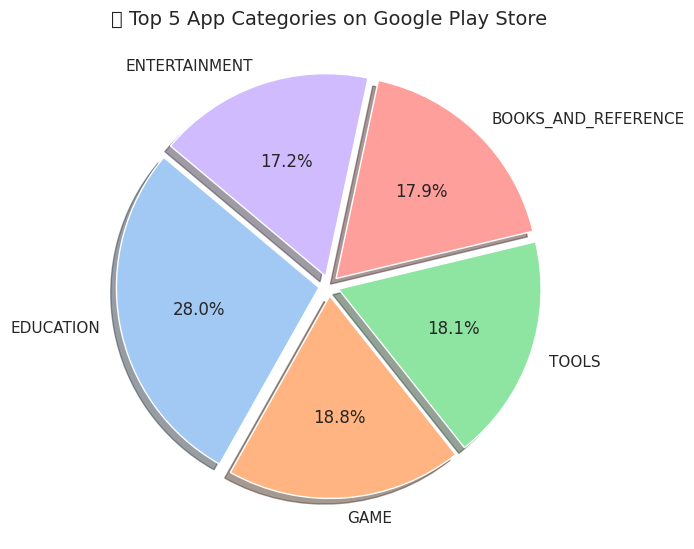

In [41]:
# Q: What are the top 5 app categories by number of apps?
top_categories_df = df.groupBy("Category").count().orderBy("count", ascending=False).limit(5).toPandas()

# Prepare pie chart
labels = top_categories_df["Category"]
sizes = top_categories_df["count"]
explode = [0.05]*5  # Slightly separate all slices for visual clarity

plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode,
        startangle=140, shadow=True, colors=sns.color_palette("pastel"),
        wedgeprops={'edgecolor': 'white'})

plt.title("🏆 Top 5 App Categories on Google Play Store", fontsize=14)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


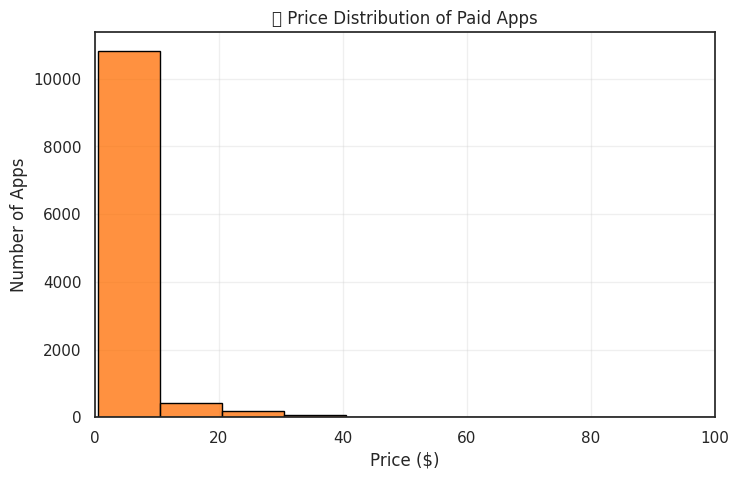

In [32]:
# Q: How are paid app prices distributed?
paid_apps = pandas_df[pandas_df["Paid_or_Free"] == "Paid"]

plt.figure(figsize=(8,5))
sns.histplot(paid_apps["Price"], bins=40, color="#ff6d00", edgecolor='black')
plt.title("💸 Price Distribution of Paid Apps")
plt.xlabel("Price ($)")
plt.ylabel("Number of Apps")
plt.grid(True, alpha=0.3)
plt.xlim(0, 100)
plt.show()


/tmp/ipython-input-33-2896971145.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_size_by_cat, x="avg(Size)", y="Category", palette="magma")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


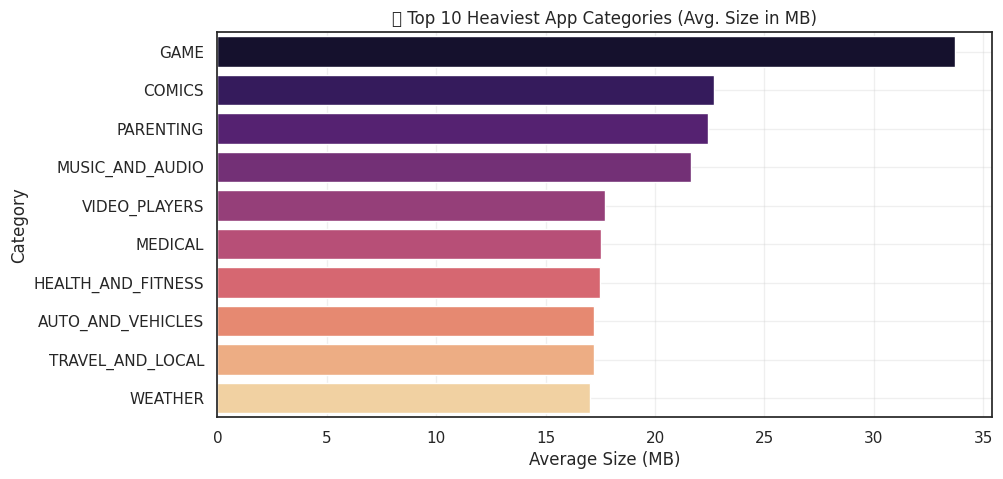

In [33]:
# Q: Which app categories tend to have the largest file sizes?
avg_size_by_cat = df.groupBy("Category").avg("Size") \
    .orderBy("avg(Size)", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10,5))
sns.barplot(data=avg_size_by_cat, x="avg(Size)", y="Category", palette="magma")
plt.title("🧱 Top 10 Heaviest App Categories (Avg. Size in MB)")
plt.xlabel("Average Size (MB)")
plt.ylabel("Category")
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipython-input-34-636726001.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_reviews, x="avg(Reviews)", y="Category", palette="coolwarm")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


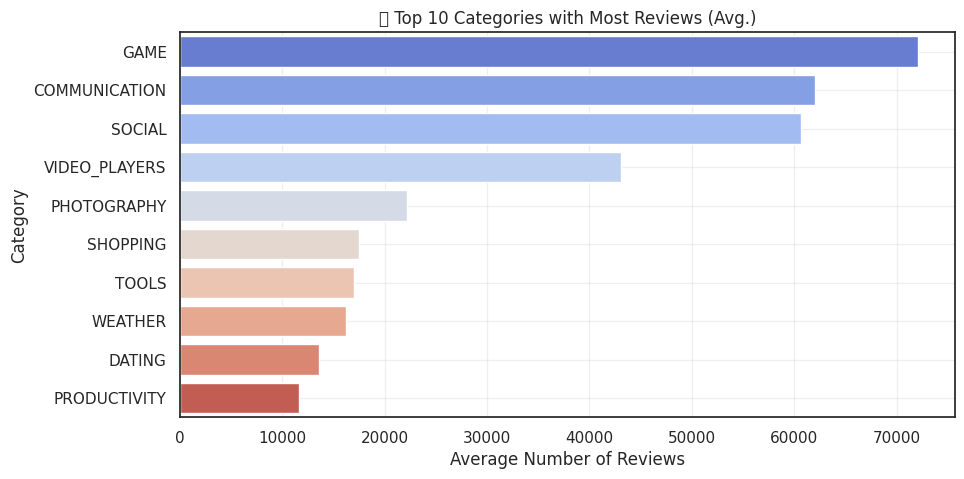

In [34]:
# Q: Which app categories receive the most reviews on average?
avg_reviews = df.groupBy("Category").avg("Reviews") \
    .orderBy("avg(Reviews)", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10,5))
sns.barplot(data=avg_reviews, x="avg(Reviews)", y="Category", palette="coolwarm")
plt.title("💬 Top 10 Categories with Most Reviews (Avg.)")
plt.xlabel("Average Number of Reviews")
plt.ylabel("Category")
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipython-input-36-3156048498.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  line_df = pandas_df.groupby("Reviews_Bin")["Installs_Lower"].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


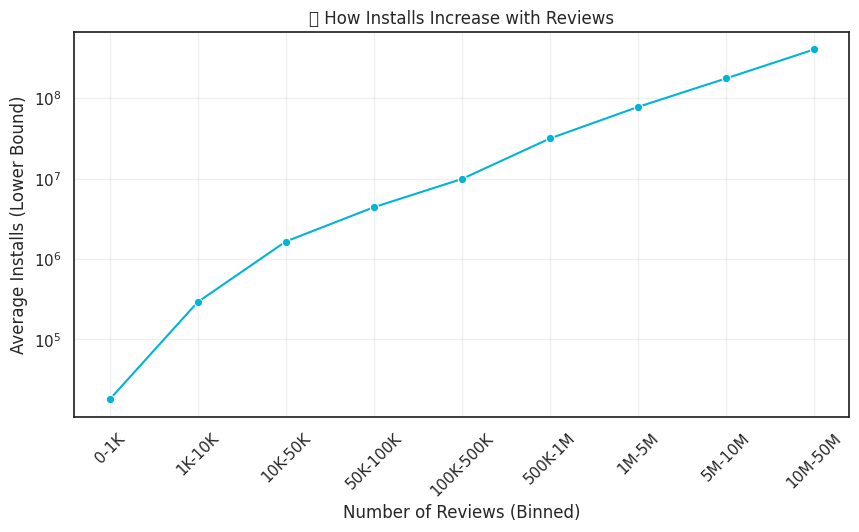

In [36]:
# Q: How do installs increase with reviews?
# Bin reviews into ranges
import pandas as pd

pandas_df['Reviews_Bin'] = pd.cut(pandas_df['Reviews'], bins=[0, 1000, 10000, 50000, 100000, 500000, 1_000_000, 5_000_000, 10_000_000, 50_000_000], labels=[
    "0-1K", "1K-10K", "10K-50K", "50K-100K", "100K-500K", "500K-1M", "1M-5M", "5M-10M", "10M-50M"
])

# Group by review bins and calculate average installs
line_df = pandas_df.groupby("Reviews_Bin")["Installs_Lower"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=line_df, x="Reviews_Bin", y="Installs_Lower", marker='o', color="#00b4d8")
plt.title("📈 How Installs Increase with Reviews")
plt.xlabel("Number of Reviews (Binned)")
plt.ylabel("Average Installs (Lower Bound)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.yscale("log")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


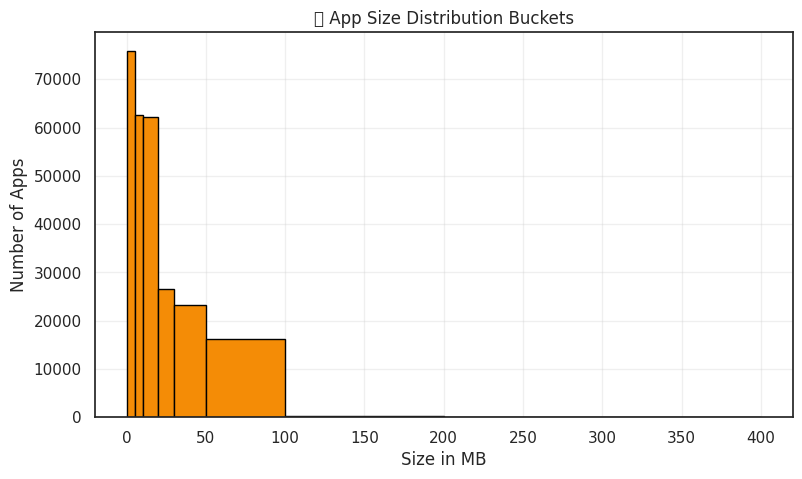

In [39]:
# Q: Are apps mostly lightweight or heavy?
plt.figure(figsize=(9,5))
plt.hist(pandas_df["Size"].dropna(), bins=[0, 5, 10, 20, 30, 50, 100, 200, 300, 400], color="#f48c06", edgecolor='black')
plt.title("📦 App Size Distribution Buckets")
plt.xlabel("Size in MB")
plt.ylabel("Number of Apps")
plt.grid(True, alpha=0.3)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


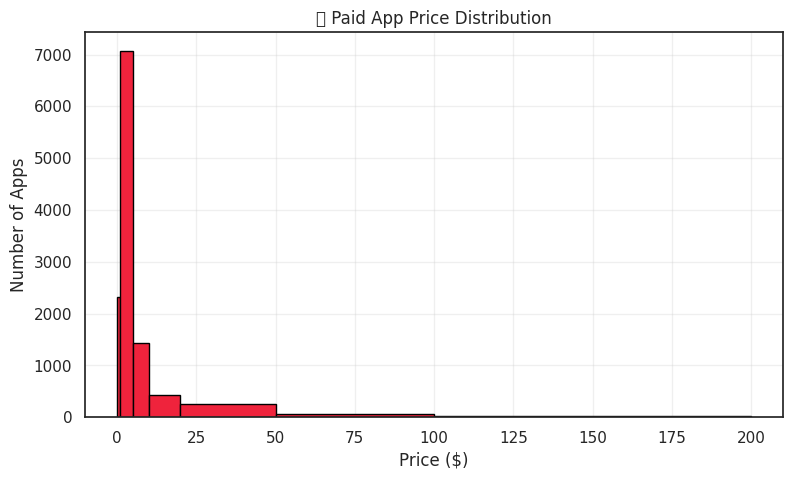

In [40]:
# Q: How are paid apps priced?
paid_apps = pandas_df[pandas_df["Paid_or_Free"] == "Paid"]

plt.figure(figsize=(9,5))
plt.hist(paid_apps["Price"], bins=[0, 1, 5, 10, 20, 50, 100, 200], color="#ef233c", edgecolor='black')
plt.title("💵 Paid App Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Number of Apps")
plt.grid(True, alpha=0.3)
plt.show()


Machine Learning

In [45]:
# Drop rows with nulls in key columns
clean_df = df.dropna(subset=["Rating", "Reviews", "Size", "Price", "Installs_Lower"])


In [46]:
from pyspark.ml.feature import VectorAssembler

# Define input features and assemble into a single feature column
feature_cols = ["Reviews", "Size", "Price", "Installs_Lower"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

assembled_df = assembler.transform(clean_df)


In [47]:
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)


In [48]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="Rating", numTrees=100, maxDepth=10)
model = rf.fit(train_data)


In [49]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="Rating", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

r2 = RegressionEvaluator(labelCol="Rating", predictionCol="prediction", metricName="r2").evaluate(predictions)

print("📊 Root Mean Squared Error (RMSE):", round(rmse, 3))
print("🎯 R-squared Score:", round(r2, 3))


📊 Root Mean Squared Error (RMSE): 0.575
🎯 R-squared Score: 0.052
